In [55]:
pip install pandas torch torchvision nibabel opencv-python timm scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
# libraries needed to visualize the slices
import pandas as pd
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [57]:
# loading csv file with all paths to the MRI files and subject information
df = pd.read_csv(r"C:\Users\gjkku\OneDrive\Documenten\CSAI year 3\Thesis\csv_binary\binary_with_mri_paths.csv", sep='\t')

# columns of the csv file to understand the structure of the dataset
print(df.columns)

# using only subjects that are non-demented (CDR 0) and very mild demented (CDR 0.5) 
df = df[df['CDR'].isin([0.0, 0.5])].dropna(subset=['CDR'])

# converting to binary labels: CDR 0 = 0 and CDR 0.5 = 1
df['label'] = df['CDR'].apply(lambda x: 0 if x == 0.0 else 1)

# printing the first 5 subjects with CDR 0 or CDR 0.5 and the count of each class to check
print(df[['CDR', 'label']].head())
print(df['label'].value_counts())

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay', 'Class', 'MRI_Path'],
      dtype='object')
   CDR  label
0  0.0      0
1  0.0      0
2  0.5      1
8  0.0      0
9  0.0      0
label
0    135
1     70
Name: count, dtype: int64


In [58]:
# dataset is imbalanced -> oversampling the minority class (CDR 0.5 / label 1) to match the majority class (CDR 0/ label 0)
df_class_0 = df[df['label'] == 0]
df_class_1 = df[df['label'] == 1].sample(n=135, replace=True, random_state=42)

# combining both classes and shuffle the dataset
balanced_df = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=42).reset_index(drop=True)

#printing class counts to check if dataset is balanced
print(balanced_df['label'].value_counts())

label
0    135
1    135
Name: count, dtype: int64


In [59]:
# function to load and preprocess MRI files (.img/.hdr files)
def MRI_slicing(img_path, target_size=(224, 224), axis_slice=1):
    # loading .img/.hdr file (NiBabel finds the img and then automatically finds the .hdr file that belongs to it)
    img = nib.load(img_path)
    data = img.get_fdata()
    
    # normalizing the image using z-score normalization -> formula = (X - mean)/ std.dev
    data = (data - np.mean(data)) / np.std(data)
    
    # getting the coronal slice of the 3D MRI image (axis_slice: sagittal = 0, coronal = 1, axial = 2)
    middle_slice = data.shape[axis_slice] // 2
    if axis_slice == 0: 
        image_slice = data[middle_slice, :, :]
    elif axis_slice == 1:
        image_slice = data[:, middle_slice, :]
    else:
        image_slice = data[:, :, middle_slice]
    
    # resizing image to (224, 224) using OpenCV
    image_slice = cv2.resize(image_slice, target_size, interpolation=cv2.INTER_AREA)
    
    # normalizing pixel values between the range [0, 1]
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))

    # returns the 2D image slice as a float32 array
    return image_slice.astype(np.float32)
    

In [60]:
pip install matplotlib 


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


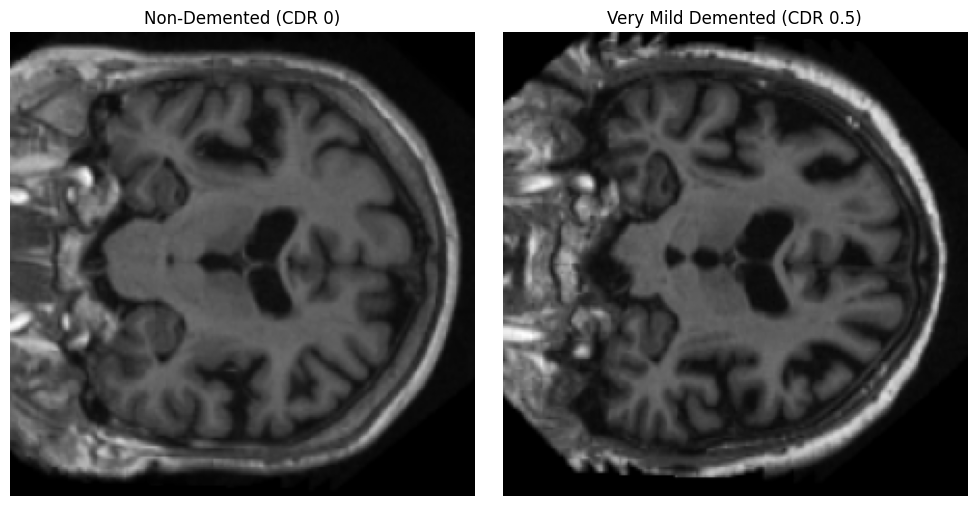

In [63]:
# one sample of each class
sample_class_0 = balanced_df[balanced_df['label'] == 0].iloc[0]  # non-demented (CDR 0)
sample_class_1 = balanced_df[balanced_df['label'] == 1].iloc[0]  # very mild demented (CDR 0.5)

# load and preprocessing the slices
slice_0 = MRI_slicing(sample_class_0['MRI_Path'], target_size=(224, 224), axis_slice=1)  # coronal slice for class 0
slice_1 = MRI_slicing(sample_class_1['MRI_Path'], target_size=(224, 224), axis_slice=1)  # coronal slice for class 1

# create figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# class 0: non-demented
axes[0].imshow(slice_0, cmap='gray')
axes[0].set_title("Non-Demented (CDR 0)")
axes[0].axis('off')  

# class 1: very mild demented
axes[1].imshow(slice_1, cmap='gray')
axes[1].set_title("Very Mild Demented (CDR 0.5)")
axes[1].axis('off')

# display plot
plt.tight_layout()
plt.show()